In [1]:
import json
import csv

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle
import sys
sys.path.append("../../")

import implicitmodules.torch as dm

In [2]:

torch.set_default_dtype(torch.float64)

In [3]:
path_datafiles = '/home/gris/Data/2DShapes/'
path_names = path_datafiles + 'NamesPLAINTEXT/'

names = []
with open(path_names + 'labels.txt', 'r') as namelist:
    for line in namelist:
        names.append(line[:-1])

In [4]:
ind_shape = 21

names_subj = []
with open(path_names + 'ShapeNames/' + names[ind_shape] + '.txt', 'r') as namelist:
    for line in namelist:
        names_subj.append(line[:-1])


In [9]:
ind_subj = 0
path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
#subj = 

In [13]:
list_subj = []
list_indi_tri = []
list_majo = []
for ind_subj in range(8):
    path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
    with open(path_subj) as f:
        subj_dict = json.load(f)
        Npts = len(subj_dict['points'])
        subj = []
        for i in range(Npts-1):
            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

        list_subj.append(np.array(subj))
        
        indi_tri = []
        Ntri = len(subj_dict['triangles'])
        for i in range(Ntri):
            indi_tri.append([subj_dict['triangles'][i]['p1'],subj_dict['triangles'][i]['p2'],subj_dict['triangles'][i]['p3']])
        list_indi_tri.append(np.array(indi_tri))
     
    path_majo = path_datafiles + 'MajorityJSON/Majority/' + names_subj[ind_subj] + '.json'
    with open(path_majo) as f:
        list_majo.append(json.load(f))

In [15]:
ind_subj_source = 0
ind_subj_target = 7

In [16]:
source = torch.tensor(list_subj[ind_subj_source])
target = torch.tensor(list_subj[ind_subj_target])

# Matching with growth model

In [17]:
aabb = dm.Utilities.aabb.AABB.build_from_points(source)

In [18]:
aabb.scale_([1.5, 2])

In [19]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
density = 300
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=source)


In [20]:
points_growth.shape

torch.Size([96, 2])

In [21]:
indi_top0 = range(0, 67)
indi_top1 = range(97, 112)
#indi_left0 = range(0, 28)
#indi_left1 = range(80, 104)
indi_bottom = range(67, 97)


part_top = np.concatenate([source[indi_top0, :], source[indi_top1, :]], axis = 0)
#part_top = source[indi_left, :]
part_bottom = source[indi_bottom, :]

In [22]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=source)
points_growthtop = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_top), intersect=True)
points_growthbottom = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_bottom), intersect=True)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [23]:
points_growth = aabb_source.scale(1.1).fill_uniform_density(density)

In [24]:
indi_growth_bottom = torch.where(points_growth[:,1] < 0.35)[0]
indi_growth_top = torch.where(points_growth[:,1] >= 0.35)[0]

In [25]:
points_growth = torch.cat([points_growthtop, points_growthbottom])
indi_growth_top = range(0, points_growthtop.shape[0])
indi_growth_bottom = range(points_growthtop.shape[0], points_growthtop.shape[0] + points_growthbottom.shape[0])

In [26]:
aabb_bottom = dm.Utilities.AABB(0.27, 0.43, 0.,0.3)

In [27]:
points_growthbottom = aabb_bottom.scale(1.1).fill_uniform_density(400)

In [28]:
points_growth = torch.cat([points_growthtop, points_growthbottom])
indi_growth_top = range(0, points_growthtop.shape[0])
indi_growth_bottom = range(points_growthtop.shape[0], points_growthtop.shape[0] + points_growthbottom.shape[0])

In [29]:
#%matplotlib qt5
C_top = torch.zeros(points_growth.shape[0], 2, 2)
C_top[indi_growth_top, 0, 0] = 1.
C_top[indi_growth_top, 1, 1] = 1.



#%matplotlib qt5
C_bottom = torch.zeros(points_growth.shape[0], 2, 2)
C_bottom[indi_growth_bottom, 0, 0] = 1.
C_bottom[indi_growth_bottom, 1, 1] = 1.

In [30]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)


In [31]:
points_growth_top = points_growth.clone().requires_grad_()
points_growth_bottom = points_growth.clone().requires_grad_()

rot_growth_top = rot_growth.clone().requires_grad_()
rot_growth_bottom = rot_growth.clone().requires_grad_()

In [32]:
scale_growth = 0.05
coeff_growth = 1.
nu = 0.001
#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth_top = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C_top, coeff=coeff_growth, nu=nu,
    gd=(points_growth_top, rot_growth_top))


#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth_bottom = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C_bottom, coeff=coeff_growth, nu=nu,
    gd=(points_growth_bottom, rot_growth_bottom))

In [33]:
sigma_trans = 0.05
coefftrans = 50.
translations = dm.DeformationModules.ImplicitModule0(2, source.shape[0], sigma_trans, nu=0.1, gd=source.clone().requires_grad_(), coeff=coefftrans)

In [34]:
rotation = dm.DeformationModules.LocalRotation(2, 2., gd=torch.tensor([[0., 0.]]).requires_grad_())

In [35]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [36]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [37]:
sigmas_varifold = [0.05, 1.]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [38]:
lam = 20.
modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, translations, growth_top, growth_bottom], [attachment], fit_gd=[False], lam=lam)
#modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.)
#modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.,precompute_callback=precompute, other_parameters={'angles': {'params': [angles]}})

In [39]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


KeyboardInterrupt: 

In [40]:
pickle.dump(modelgrowth.init_manifold, open( "/home/gris/Results/ImplicitModules/Tree/Mixte_init_manifold" + "_lam_" + str(lam) + "_coefftrans_" + str(coefftrans) + str(ind_subj_source) + '_' + str(ind_subj_target) + ".p", "wb" ) )


In [49]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = modelgrowth.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.08957173212780595,
 0.7440834158156098,
 -0.06710904752392935,
 1.0508147165487585)

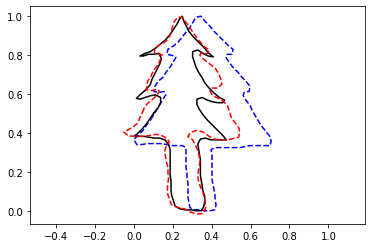

In [50]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], '--r')
plt.axis('equal')

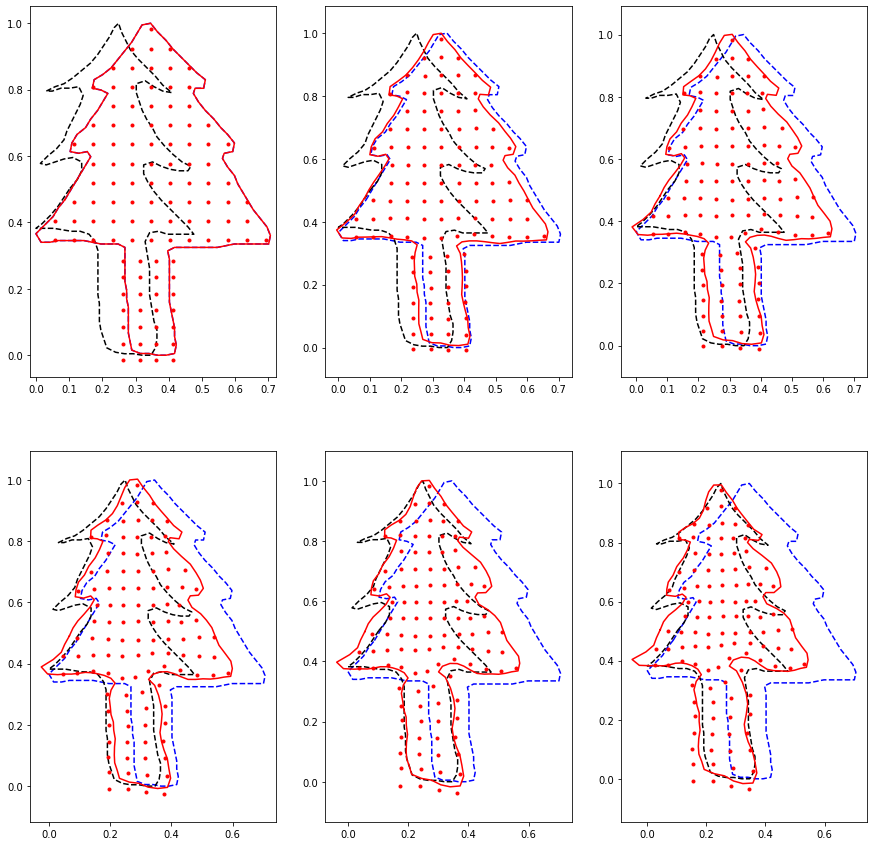

In [51]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    #if i<5:
    #    #print(intermediates['controls'][2*i][3])
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates['states'][2*i].gd[0].detach().numpy()[:,0], intermediates['states'][2*i].gd[0].detach().numpy()[:,1], 'r')
    plt.plot(intermediates['states'][2*i].gd[3][0].detach().numpy()[:,0], intermediates['states'][2*i].gd[3][0].detach().numpy()[:,1], '.r')
    plt.axis('equal')

In [56]:
for i in range(10):
    print(intermediates['controls'][i][4])

tensor([ 0.1862, -0.0832])
tensor([ 0.1923, -0.0695])
tensor([ 0.2312, -0.0574])
tensor([ 0.2696, -0.0428])
tensor([ 0.2716, -0.0229])
tensor([0.2403, 0.0025])
tensor([0.1924, 0.0305])
tensor([0.1439, 0.0571])
tensor([0.1032, 0.0817])
tensor([0.0654, 0.1054])


In [55]:
for i in range(10):
    print(intermediates['controls'][i][3])

tensor([-0.4798, -0.0395])
tensor([-0.4688, -0.0495])
tensor([-0.4465, -0.0580])
tensor([-0.4006, -0.0688])
tensor([-0.3284, -0.0826])
tensor([-0.2443, -0.0939])
tensor([-0.1704, -0.0971])
tensor([-0.1226, -0.0923])
tensor([-0.1011, -0.0828])
tensor([-0.0919, -0.0712])


## Follow each module 

In [10]:
# We extract the modules of the models and fill the right manifolds.
silent = dm.DeformationModules.SilentBase(copy.copy(modelgrowth.init_manifold.clone().manifolds[0]), label='sil')
modules = dm.DeformationModules.CompoundModule(copy.copy(modelgrowth.modules))
modules.manifold.fill(modelgrowth.init_manifold.clone(), copy=True)
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
#translation = copy.copy(modelgrowth.modules[0])
#growth2 = copy.copy(modelgrowth.modules[1])

NameError: name 'modelgrowth' is not defined

In [50]:
CompoundModule = dm.DeformationModules.CompoundModule([deformation_grid] + modules.modules)

In [51]:
CompoundModule.modules

In [57]:
# We construct the controls list we will give will shooting
controls = [[torch.tensor([]), torch.tensor([]), 0.*control[1], 1.*control[2], torch.tensor([0.*control[3][0], 0.*control[3][1]]), torch.tensor([0.*control[4][0], 0.*control[4][1]])] for control in intermediates['controls']]

In [58]:
intermediates_cont = {}
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(CompoundModule.modules), shoot_solver, shoot_it, controls=controls, intermediates=intermediates_cont)

In [59]:
growth_deformed_source = silent.manifold.gd.detach()
growth_deformed_grid = deformation_grid.togrid()

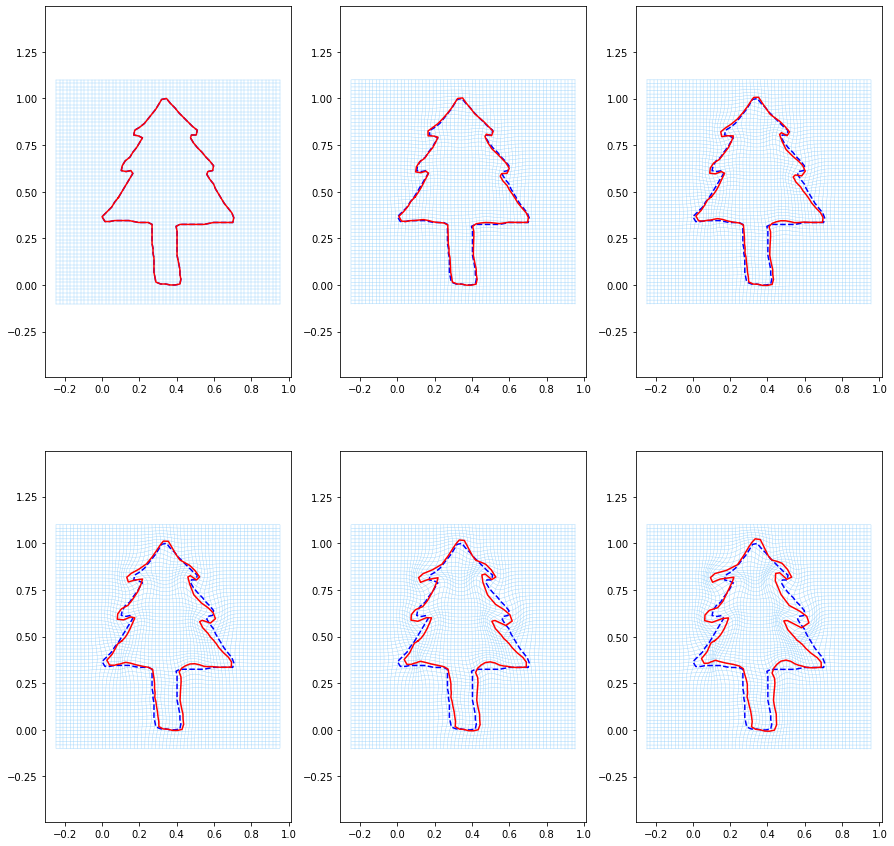

In [60]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    #if i<5:
    #    print(intermediates_cont['controls'][2*i][3])
    deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
    deformation_grid_t.manifold.fill_gd(intermediates_cont['states'][2*i].gd[0].detach())
    growth_deformed_grid_t = deformation_grid_t.togrid()
    dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    #plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,0], intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

# Working on images

In [11]:
source_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/tree01.png', origin='lower')
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/tree03.png', origin='lower')

In [12]:
source_image.shape

torch.Size([256, 256])

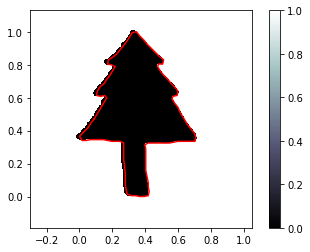

In [13]:

extent_source = dm.Utilities.AABB( -0.3, 1.05, -0.19, 1.13)

plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'r')
plt.colorbar()

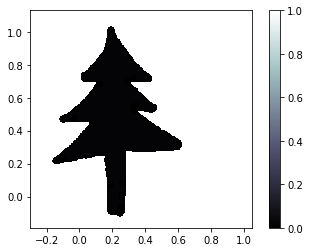

In [24]:
extent_target = dm.Utilities.AABB( -0.3, 1.05, -0.19, 1.13)
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/tree08.png', origin='lower')
plt.imshow(target_image.numpy(), origin='lower', cmap='bone', extent=extent_target.totuple())
#plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.colorbar()

In [28]:
aabb = dm.Utilities.aabb.AABB.build_from_points(source)

In [29]:
aabb.scale_([1.5, 2])

In [30]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
density = 300
#points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=source)


In [32]:
indi_top0 = range(0, 67)
indi_top1 = range(97, 112)
#indi_left0 = range(0, 28)
#indi_left1 = range(80, 104)
indi_bottom = range(67, 97)


part_top = np.concatenate([source[indi_top0, :], source[indi_top1, :]], axis = 0)
#part_top = source[indi_left, :]
part_bottom = source[indi_bottom, :]

(-0.0353095, 0.7414995, -0.05, 1.05)

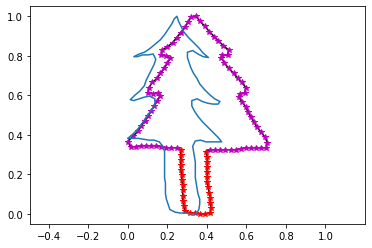

In [33]:
plt.plot(source[:,0], source[:,1], 'k')
plt.plot(part_top[:,0], part_top[:,1], '*m')
plt.plot(part_bottom[:,0], part_bottom[:,1], '*r')

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
#for i in range(np.shape(indi_tri)[0]):
    #plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    #t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    
plt.axis('equal')

In [41]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=source)
points_growthtop = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_top), intersect=True)
#points_growthbottom = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_bottom), intersect=True)


In [42]:
aabb_bottom = dm.Utilities.AABB(0.27, 0.43, 0.,0.3)

In [43]:
points_growthbottom = aabb_bottom.scale(1.1).fill_uniform_density(400)

In [35]:
points_growth = aabb_source.scale(1.1).fill_uniform_density(density)

(-0.3, 1.05, -0.19, 1.13)

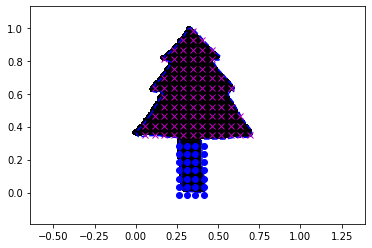

In [44]:
plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growthtop[:,0], points_growthtop[:,1], 'xm')
plt.plot(points_growthbottom[:,0], points_growthbottom[:,1], 'ob')
plt.axis('equal')

In [35]:
#%matplotlib qt5
C_top = torch.zeros(points_growth.shape[0], 2, 2)
C_top[indi_growth_top, 0, 0] = 1.
C_top[indi_growth_top, 1, 1] = 1.



#%matplotlib qt5
C_bottom = torch.zeros(points_growth.shape[0], 2, 2)
C_bottom[indi_growth_bottom, 0, 0] = 1.
C_bottom[indi_growth_bottom, 1, 1] = 1.

In [36]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)


In [37]:
points_growth_top = points_growth.clone().requires_grad_()
points_growth_bottom = points_growth.clone().requires_grad_()

rot_growth_top = rot_growth.clone().requires_grad_()
rot_growth_bottom = rot_growth.clone().requires_grad_()

In [38]:
scale_growth = 0.05
coeff_growth = 1.
nu = 0.001
#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth_top = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C_top, coeff=coeff_growth, nu=nu,
    gd=(points_growth_top, rot_growth_top))


#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth_bottom = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C_bottom, coeff=coeff_growth, nu=nu,
    gd=(points_growth_bottom, rot_growth_bottom))

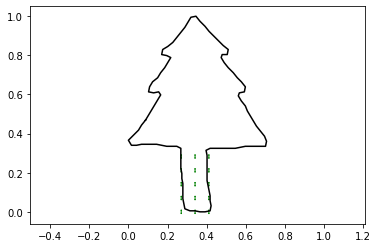

In [38]:
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C_bottom, R=rot_growth, c_index=3, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [39]:
sigma_trans = 0.05
translations = dm.DeformationModules.ImplicitModule0(2, source.shape[0], sigma_trans, nu=0.1, gd=source.clone().requires_grad_(), coeff=50.)

In [40]:
rotation = dm.DeformationModules.LocalRotation(2, 2., gd=torch.tensor([[0., 0.]]).requires_grad_())

In [41]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [42]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [43]:
sigmas_varifold = [0.05, 1.]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [47]:
modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, translations, growth_top, growth_bottom], [attachment], fit_gd=[False], lam=10.)
#modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.)
#modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.,precompute_callback=precompute, other_parameters={'angles': {'params': [angles]}})

In [45]:
attachment_image = dm.Attachment.EuclideanPointwiseDistanceAttachment()

In [62]:
attachment_image(source_image, target_image)

RuntimeError: The size of tensor a (256) must match the size of tensor b (421) at non-singleton dimension 0

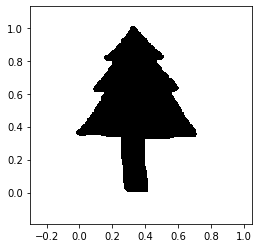

In [48]:
plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())


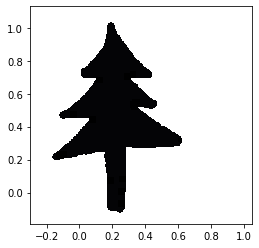

In [61]:
plt.imshow(target_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())


In [50]:
source_image.shape

torch.Size([256, 256])

In [51]:
target_image.shape

torch.Size([414, 421])

In [63]:
import opencv

ModuleNotFoundError: No module named 'opencv'